In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, librosa
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import IPython.display as ipd
import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras import backend as K
from keras.layers import Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

In [ ]:
vggish = hub.load('https://tfhub.dev/google/vggish/1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Class : Pop



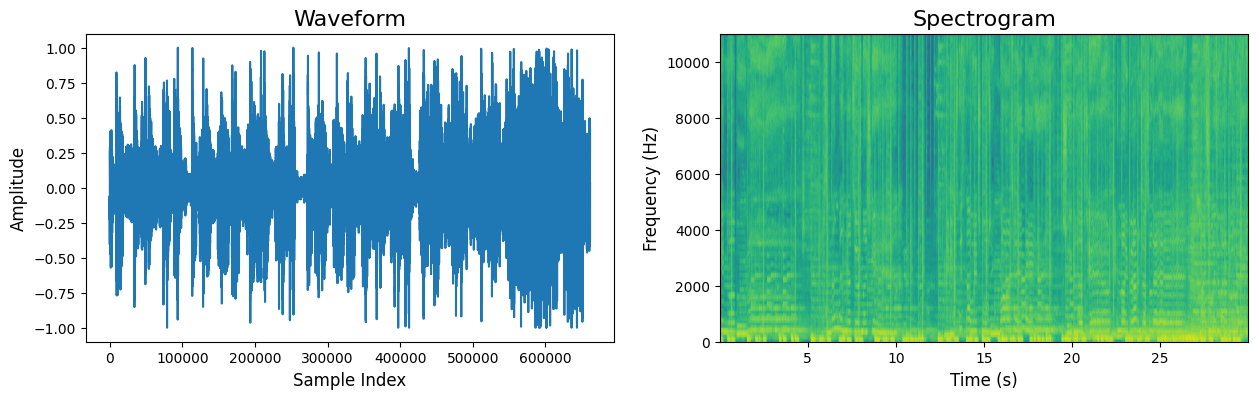

In [ ]:
# Displaying a random waveform and spectrogram
audioFile = '/content/drive/MyDrive/genres_original/pop/pop.00000.wav'
waveform, sampleRate = librosa.load(audioFile)
print('Class : Pop\n')
ipd.display(ipd.Audio(waveform, rate = sampleRate))


# Displaying waveform
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(waveform)
plt.title('Waveform', fontsize = 16)
plt.xlabel('Sample Index', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)


# Displaying spectrogram
plt.subplot(1, 2, 2)
plt.specgram(waveform, Fs = sampleRate)
plt.title('Spectrogram', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Frequency (Hz)', fontsize = 12)

plt.show()

**Mel-Spectrogram**

Class : Pop



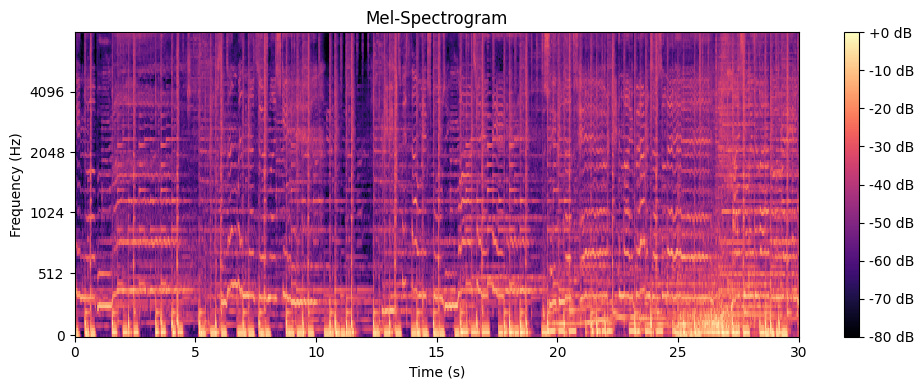

In [ ]:
audioFile = '/content/drive/MyDrive/genres_original/pop/pop.00000.wav'
waveform, sampleRate = librosa.load(audioFile)
print('Class : Pop\n')
ipd.display(ipd.Audio(waveform, rate = sampleRate))

# Generate a Mel-spectrogram using librosa
mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sampleRate, n_mels=128, fmax=8000)

# Convert power spectrogram (amplitude squared) to decibel (dB) units for better visualization
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plotting the Mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sampleRate, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

**Time Domain Representation**

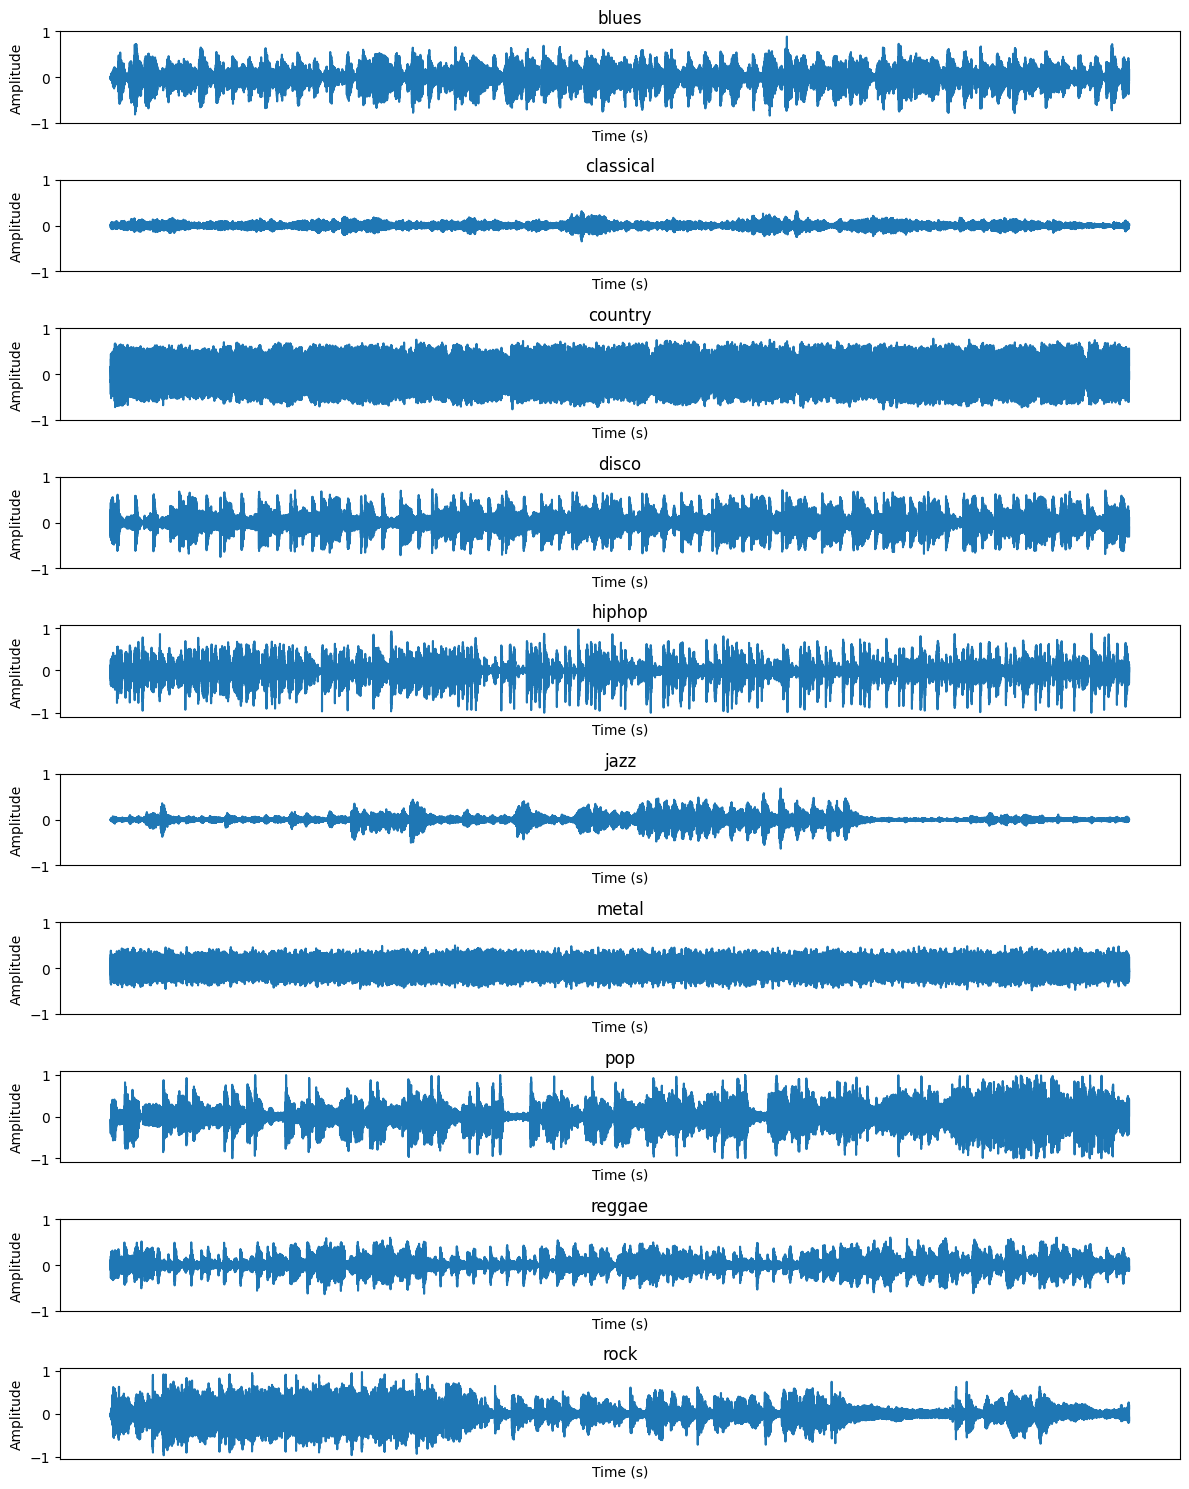

In [ ]:
# Define the path to your main genre directory
base_path = '/content/drive/MyDrive/genres_original/'

# List of genres
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Plot the waveform for one sample from each genre
plt.figure(figsize=(12, 15))
for i, genre in enumerate(genres):
    # Load an example file from each genre
    file_path = os.path.join(base_path, genre, f"{genre}.00000.wav")
    waveform, sample_rate = librosa.load(file_path)

    # Plot the waveform
    plt.subplot(10, 1, i + 1)
    plt.plot(waveform)
    plt.title(genre, fontsize=12)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Amplitude', fontsize=10)
    plt.xticks([])
    plt.yticks([-1, 0, 1])

plt.tight_layout()
plt.show()

In [ ]:
import random
import librosa
import numpy as np

# Audio augmentation functions
def augment_audio(waveform, sr):
    if random.choice([True, False]):
        # Time stretching
        stretch_rate = random.uniform(0.8, 1.2)
        waveform = librosa.effects.time_stretch(waveform, stretch_rate)

    if random.choice([True, False]):
        # Pitch shifting
        n_steps = random.randint(-2, 2)
        waveform = librosa.effects.pitch_shift(waveform, sr, n_steps)

    if random.choice([True, False]):
        # Adding white noise
        noise_amp = 0.005 * np.random.uniform() * np.amax(waveform)
        waveform = waveform + noise_amp * np.random.normal(size=waveform.shape)

    return waveform


In [ ]:
# Function to extract audio features with optional augmentation
def extractFeatures(audioFile, augment=False):
    try:
        waveform, sr = librosa.load(audioFile)
        waveform, _ = librosa.effects.trim(waveform)

        if augment:
            waveform = augment_audio(waveform, sr)

        # convert to numpy arrays
        return vggish(waveform).numpy()
    except:
        return None


In [ ]:
root = '/content/drive/MyDrive/genres_original/'
data = []
for folder in os.listdir(root):
    folderPath = os.path.join(root, folder)

    for file in tqdm(os.listdir(folderPath), desc=f'Processing folder {folder}'):
        filePath = os.path.join(folderPath, file)

        # Extract features for original audio
        features = extractFeatures(filePath)
        if features is not None:
            data.append([features, folder])

        # Extract features for augmented audio (optional)
        features_aug = extractFeatures(filePath, augment=True)
        if features_aug is not None:
            data.append([features_aug, folder])


Processing folder jazz:  99%|█████████▉| 99/100 [04:04<00:02,  2.97s/it]<ipython-input-7-c2063e03d9be>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(audioFile)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing folder reggae: 100%|██████████| 100/100 [03:43<00:00,  2.23s/it]


In [ ]:
# Converting list into dataframe
data = pd.DataFrame(data, columns = ['Features', 'Class'])
data.head()

Features Class
0  [[-0.7057308, 0.060510367, -0.06372285, -0.201...   pop
1  [[-0.87203634, 0.04775934, 0.06917676, -0.6588...   pop
2  [[-0.47646984, -0.026530832, 0.30067828, -0.07...   pop
3  [[-0.5397104, -0.07291135, 0.22526783, -0.0978...   pop
4  [[-0.5053344, 0.60576844, 0.14469227, -0.53601...   pop

<ipython-input-10-04eb5680c905>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = data['Class'], palette = 'viridis')


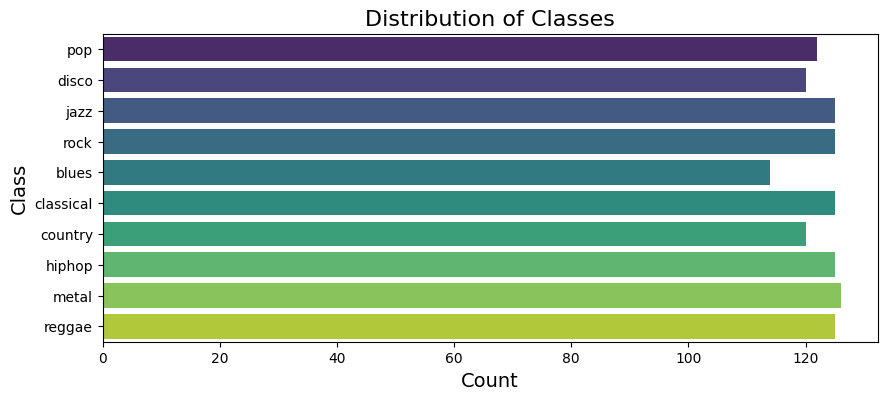

In [ ]:
# Plotting count distribution of classes
plt.figure(figsize = (10, 4))
sns.countplot(y = data['Class'], palette = 'viridis')
plt.title('Distribution of Classes', fontsize = 16)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

In [ ]:
# Padding or truncating the arrays to a fixed length
X = data['Features'].tolist()
X = pad_sequences(X, dtype = 'float32', padding = 'post', truncating = 'post')
X.shape

(1227, 43, 128)

In [ ]:
# Flatten the data to 2D
X = X.reshape(X.shape[0], -1)
print("New shape of X after flattening:", X.shape)  # Should be 2D, like (num_samples, flattened_dim)

New shape of X after flattening: (1227, 5504)


In [ ]:
# Flatten X for scaling, then reshape back
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Encoding class labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['Class'])
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Define the Deep Convolutional Neural Network model
class DeepCNNModel:
    def __init__(self, input_shape, num_classes, learning_rate=0.001):
        self.model = Sequential()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate=learning_rate
        self._build_model()

    def _build_model(self):
        # Input layer
        self.model.add(layers.Input(shape=self.input_shape))

        # First convolutional layer
        self.model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
        self.model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Second convolutional layer
        self.model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
        self.model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Third convolutional layer
        self.model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        self.model.add(layers.MaxPooling2D(pool_size=(2, 2)))


        # Flatten the output before the dense layers
        self.model.add(layers.Flatten())

        # Fully connected layer
        self.model.add(layers.Dense(1024, activation='relu'))
        self.model.add(layers.Dropout(0.6))

        # Optionally, add another dense layer if needed
        self.model.add(layers.Dense(512, activation='relu'))
        self.model.add(layers.Dropout(0.5))

        # Output layer
        self.model.add(layers.Dense(self.num_classes, activation='softmax'))

        # Compile the model
        optimizer=RMSprop(learning_rate=self.learning_rate,rho=0.9)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, X_val, y_val, epochs=30, batch_size=32):
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])
        return history

    def evaluate(self, X_test, y_test):
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        return test_loss, test_accuracy

    def predict(self, X):
        predictions = self.model.predict(X)
        return np.argmax(predictions, axis=1)

In [ ]:
# Prepare the data for CNN
# Reshape X_train and X_test to fit the CNN input shape (samples, height, width, channels)
# Here we assume mel-spectrograms of size 128xN (128 mel bands, N time steps)
X_train_cnn = X_train.reshape(X_train.shape[0], 128, -1, 1)  # Add channel dimension
X_test_cnn = X_test.reshape(X_test.shape[0], 128, -1, 1)

In [ ]:
# Initialize the deep CNN model
num_classes = y.shape[1]  # Number of unique classes
deep_cnn_model = DeepCNNModel(input_shape=(128, X_train_cnn.shape[2], 1), num_classes=num_classes, learning_rate=0.001)

In [ ]:
#Train the model
history = deep_cnn_model.train(X_train_cnn, y_train, X_test_cnn, y_test, epochs=30, batch_size=32)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.0989 - loss: 8.7990 - val_accuracy: 0.1016 - val_loss: 2.2851
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - accuracy: 0.1010 - loss: 2.3239 - val_accuracy: 0.1057 - val_loss: 2.2464
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.1746 - loss: 2.2404 - val_accuracy: 0.3252 - val_loss: 1.8768
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.3522 - loss: 1.8875 - val_accuracy: 0.4512 - val_loss: 1.5401
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.4747 - loss: 1.4963 - val_accuracy: 0.5488 - val_loss: 1.2941
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.5370 - loss: 1.3345 - val_accuracy: 0.5691 - val_loss: 1.2985
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.5931 - loss: 1.1908 - val_accuracy: 0.6301 - val_loss: 1.0330
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.6730 - loss: 0.9580 - val_accuracy: 0.6382 - v

In [ ]:
# Evaluate the model
deep_cnn_model.evaluate(X_test_cnn, y_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 969ms/step - accuracy: 0.7161 - loss: 0.7706
Test Loss: 0.7544
Test Accuracy: 0.7236


(0.7543712854385376, 0.7235772609710693)

In [ ]:
# Predict class probabilities for the test set
y_pred_probs = deep_cnn_model.model.predict(X_test_cnn)

# Convert probabilities to class labels (one-hot to integer labels)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=encoder.classes_)
print(report)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
              precision    recall  f1-score   support

       blues       0.80      0.52      0.63        23
   classical       0.92      0.92      0.92        25
     country       0.61      0.71      0.65        24
       disco       0.64      0.58      0.61        24
      hiphop       0.82      0.92      0.87        25
        jazz       0.80      0.96      0.87        25
       metal       0.78      0.84      0.81        25
         pop       0.68      0.52      0.59        25
      reggae       0.64      0.72      0.68        25
        rock       0.54      0.52      0.53        25

    accuracy                           0.72       246
   macro avg       0.72      0.72      0.72       246
weighted avg       0.72      0.72      0.72       246



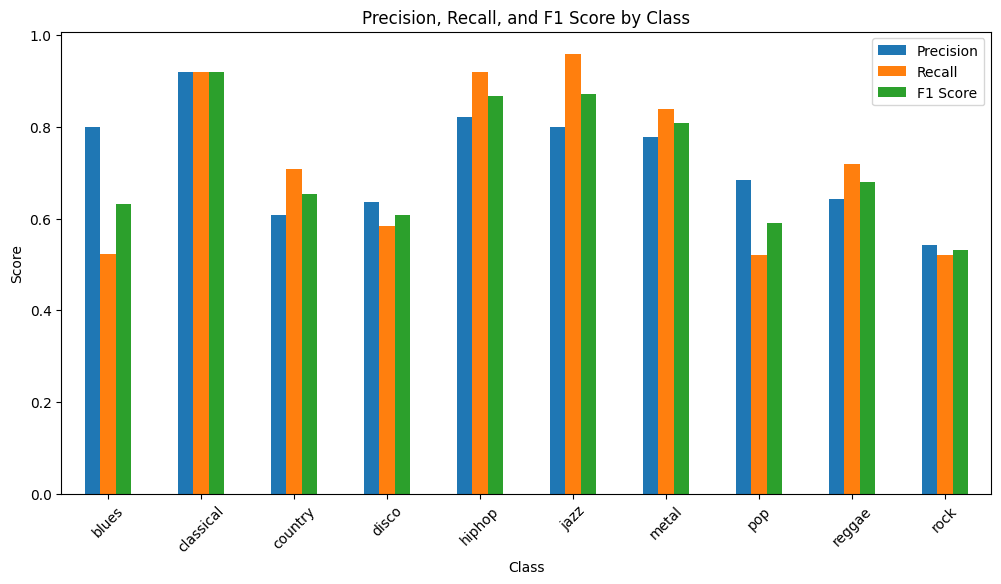

In [ ]:
# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Plot precision, recall, and f1-score for each class
metrics_df = pd.DataFrame({
    'Class': encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

metrics_df.set_index('Class', inplace=True)
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Precision, Recall, and F1 Score by Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.show()

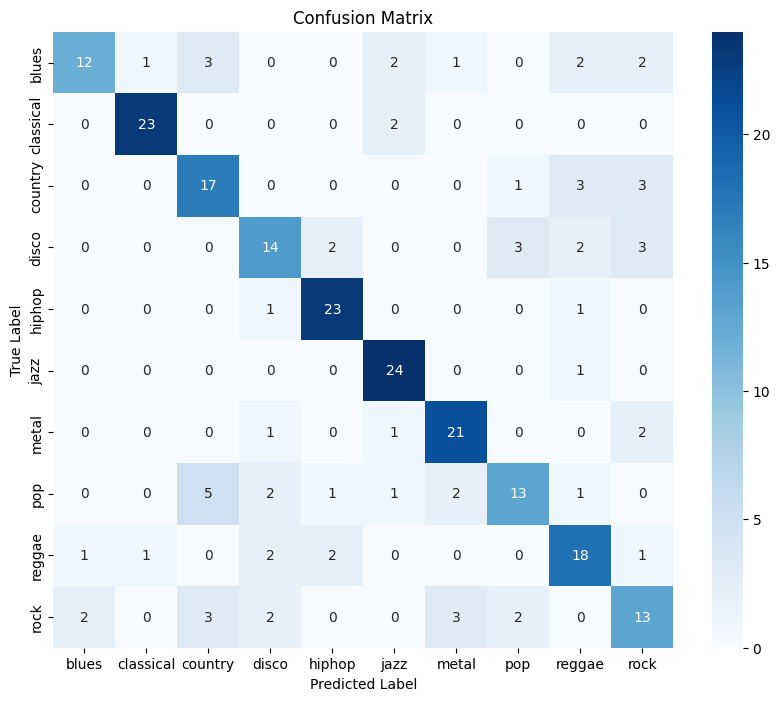

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

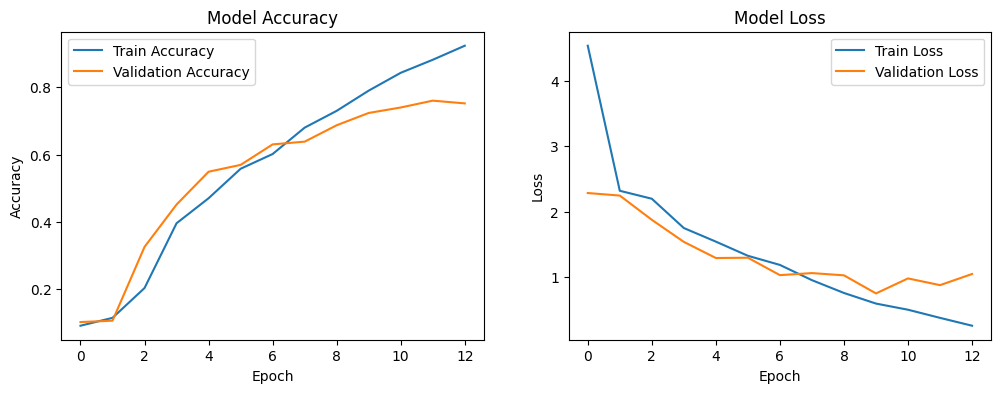

In [ ]:
# Optionally, plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()